# Halo model power spectra
This example illustrates how to use CCL to calculate power spectra using the halo model.

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
from scipy.special import erf
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


## Preliminaries
Generate a cosmology object and a couple of $k$ (comoving wavenumber) and $a$ (scale factor) arrays.

In [3]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

ccl.Cosmology = a class that stores information about cosmological parameters and associated data (e.g. distances, power spectra).   
The values of cosmological parameters can then be looked up by name (e.g. cosmo["sigma8"]).  

- **Omega_c** ($\Omega_c$) (`float`) – Cold dark matter density fraction.
- **Omega_b** (`float`) – Baryonic matter density fraction.
- **h** (`float`) – Hubble constant divided by 100 km/s/Mpc; unitless.
- **A_s** (`float`) – Power spectrum normalization. Exactly one of A_s and sigma_8 is required.
- **sigma8** (`float`) – Variance of matter density perturbations at an 8 Mpc/h scale. Exactly one of A_s and sigma_8 is required. Note that, if a value of sigma8 is passed, CCL will enforce the linear matter power spectrum to be correctly normalised to this value of $\sigma_8$, even in the presence of other parameters (e.g. modified gravity parameters) that might affect the overall power spectrum normalization.
- **n_s** (`float`) – Primordial scalar perturbation spectral index.
- **Omega_k** (`float`) – Curvature density fraction. Defaults to 0.
- **Omega_g** (`float`) – Density in relativistic species except massless neutrinos. The default of None corresponds to setting this from the CMB temperature. Note that if a non-None value is given, this may result in a physically inconsistent model because the CMB temperature will still be non-zero in the parameters.
- **Neff** (`float`) – Effective number of massless neutrinos present. Defaults to 3.044.
- **m_nu** (`float or array`) – Mass in eV of the massive neutrinos present. Defaults to 0. If a sequence is passed, it is assumed that the elements of the sequence represent the individual neutrino masses.
- **mass_split** (`str`) – Type of massive neutrinos. Should be one of ‘single’, ‘equal’, ‘normal’, ‘inverted’. ‘single’ treats the mass as being held by one massive neutrino. The other options split the mass into 3 massive neutrinos. Ignored if a sequence is passed in m_nu. Default is ‘normal’.
- **w0** (`float`) – First order term of dark energy equation of state. Defaults to -1.
- **wa** (`float`) – Second order term of dark energy equation of state. Defaults to 0.
- **T_CMB** (`float`) – The CMB temperature today. The default value is 2.7255.
- **T_ncdm** (`float`) – Non-CDM temperature in units of photon temperature. The default is 0.71611.
- **transfer_function** (`str or EmulatorPk`) – The transfer function to use. Defaults to ‘boltzmann_camb’.
- **matter_power_spectrum** (`str or EmulatorPk`) – The matter power spectrum to use. Defaults to ‘halofit’.
- **baryonic_effects** (`Baryons or None`) – The baryonic effects model to use. Options are None (no baryonic effects), or a Baryons object.
- **mg_parametrization** (`ModifiedGravity or None`) – The modified gravity parametrization to use. Options are None (no MG), or a ModifiedGravity object. Currently, only MuSigmaMG is supported.
- **extra_parameters** (`dict`) – Dictionary holding extra parameters. Currently supports extra parameters for CAMB. Details described below [in documentation]. Defaults to None.

In [11]:
# Wavenumbers and scale factors
k_arr = np.geomspace(1E-4,1E1,256) # np.geomspace(start, stop, num=50, endpoint=True, dtype=None, axis=0)
# Returns numbers spaced evenly on a log scale (a geometric progression). Similar to logspace, but with endpoints specified directly. 
# Each output sample is a constant multiple of the previous.
a_arr = np.linspace(0.1,1,32)

Let us also initialize a series of halo model quantities. We will need:
- A halo mass definition.
- A concentration-mass relation.
- A halo mass function parametrization.
- A halo bias parametrization.
- Halo profiles corresponding to the quantities we want to compute the power spectrum of.

In [15]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200m)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(mass_def=hmd_200m)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.HaloProfileNFW(mass_def=hmd_200m, concentration=cM, fourier_analytic=True)

Additionally, in order to showcase the flexibility of the current halo model implementation, let us create our own halo profile characterizing the galaxy overdensity using a Halo Occupation Distribution model. We will use the same parametrization used in Nicola et al. https://arxiv.org/abs/1912.08209.

In [18]:
pg = ccl.halos.HaloProfileHOD(mass_def=hmd_200m, concentration=cM)

## Halo model power spectra

The halo-model power spectrum for two quantities defined by their halo profiles $u$ and $v$ is given by
\begin{equation}
   P_{uv}(k) = \int dM\,n(M)\,\langle u(k|M)\,v(k|M)\rangle + \left[\int dM\,n(M)\,b(M)\,\langle u(k|M)\rangle\right]\,\left[\int dM\,n(M)\,b(M)\,\langle v(k|M)\rangle\right]\,P_{\rm lin}(k).
\end{equation}

The first part, the so-called "one-halo" term, involves the Fourier-space two-point cumulant of the two profiles ($\langle u(k|M)\,v(k|M)\rangle$). This is often approximated by the product of the profile means ($\langle u(k|M)\rangle\,\langle v(k|M)\rangle$), but this is not correct in general (e.g. for the HOD profile). For this reason, the computation of the halo model power spectrum in CCL requires three main ingredients:
- The two profiles to be correlated.
- The linear matter power spectrum. Together with the profile means it controls the 2-halo term.
- The two-point cumulant of the two profiles, controlling the 1-halo term. By default we will set this to the product of the profile means, but we provide ways to define your own two-points.

Let's start by computing the different auto- and cross-correlations between matter and galaxy overdensities at $z=0$.

The first step is creating a `HMCalculator` object that essentially takes care of the mass integrals.

In [22]:
hmc = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM, mass_def=hmd_200m)

This class (`HMCalculator`) implements a set of methods that can be used to compute various halo model quantities. 
A lot of these quantities will involve integrals of the sort:   
\begin{equation}
   \int dM\,n(M,a)\,f(M,k,a)\,
\end{equation}
where $n(M,a)\,$ is the halo mass function, and $f$is an arbitrary function of mass, scale factor and Fourier scales.

Parameters:

        mass_function (str or MassFunc) – the mass function to use

        halo_bias (str or HaloBias) – the halo bias function to use

        mass_def (str or MassDef) – the halo mass definition to use

        log10M_min (float) – lower bound of the mass integration range (base-10 logarithmic).

        log10M_max (float) – lower bound of the mass integration range (base-10 logarithmic).

        nM (int) – number of uniformly-spaced samples in 

to be used in the mass integrals.

integration_method_M (str) – integration method to use in the mass integrals. Options: “simpson” and “spline”.

Now let's start computing the different power spectra. Note that, because we are interested in overdensities, we normalize by the means of both quantities. This is done by setting the `normprof` parameters of all method calls to `True`.

### 1. Matter-matter

In [31]:
pk_MM = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1., pM)

# https://ccl.readthedocs.io/en/latest/api/pyccl.halos.pk_2pt.html#pyccl.halos.pk_2pt.halomod_power_spectrum

### 2. Galaxy-matter

In [34]:
pk_gM = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1., pg, prof2=pM)

### 3. Galaxy-galaxy

In this case we have a non-trivial two-point cumulant (see Eq. 3.9 of https://arxiv.org/abs/1909.09102). This can be done through the `Profile2pt` class (of which there is one subclass specific for HOD).

In [37]:
HOD2pt = ccl.halos.Profile2ptHOD()
    
pk_gg = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1.,
                                         pg, prof_2pt=HOD2pt)

OK, great, now let's plot the power spectra!

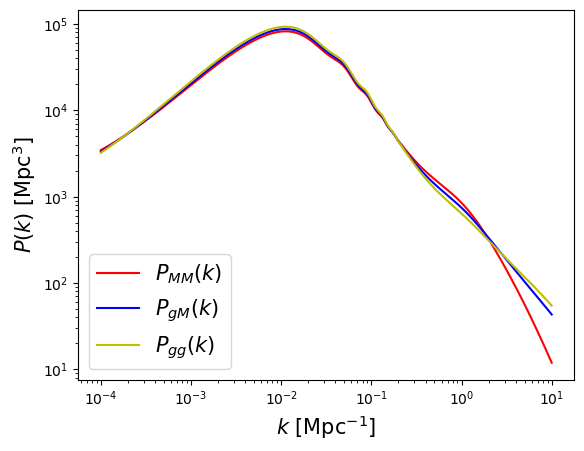

In [40]:
plt.figure()
plt.plot(k_arr, pk_MM, 'r-', label='$P_{MM}(k)$')
plt.plot(k_arr, pk_gM, 'b-', label='$P_{gM}(k)$')
plt.plot(k_arr, pk_gg, 'y-', label='$P_{gg}(k)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^3]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15);

## 2D power spectra and $C_\ell$s

The `HMCalculator` objects can also provide `Pk2D` power spectrum objects that can then be used to perform Limber integrals and compute angular power spectra. Let's do so for the 3D cross correlations we just looked at.

First, let's create two CCL tracers, a `NumberCountsTracer` that we will associate with the galaxy overdensity, and a `WeakLensing` tracer that we will associate with the matter overdensity.

In [55]:
z_arr = np.linspace(0,0.5,256)
nz_arr = np.exp(-((z_arr - 0.25) / 0.05)**2)

# We give it unit bias because the HOD P(k) is already biased
t_g = ccl.NumberCountsTracer(cosmo, dndz=(z_arr, nz_arr), bias=(z_arr, np.ones_like(z_arr)), has_rsd=False)
 # look up functions 
t_M = ccl.WeakLensingTracer(cosmo, dndz=(z_arr, nz_arr))

Now let's create `Pk2D` objects for the three cross correlations

In [45]:
pk_MMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pM,
                                lk_arr=np.log(k_arr), a_arr=a_arr)
 # look up the Pk2D function in docs
pk_gMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pg, prof2=pM,
                                lk_arr=np.log(k_arr), a_arr=a_arr)
pk_ggf = ccl.halos.halomod_Pk2D(cosmo, hmc, pg, prof_2pt=HOD2pt,
                                lk_arr=np.log(k_arr), a_arr=a_arr)

Now let's use these to compute $C_\ell$s

In [57]:
# recheck what CCL tracers are in this case
l_arr = np.unique(np.geomspace(2, 1000, 64).astype(int))

# and look up function
cl_MM = ccl.angular_cl(cosmo, t_M, t_M, l_arr, p_of_k_a=pk_MMf)
cl_gM = ccl.angular_cl(cosmo, t_g, t_M, l_arr, p_of_k_a=pk_gMf)
cl_gg = ccl.angular_cl(cosmo, t_g, t_g, l_arr, p_of_k_a=pk_ggf)


Alright, plotting time!

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:4: SyntaxWarning: invalid escape sequence '\g'
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_80754/3855117642.py:3: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(l_arr, lfac * cl_MM, 'r-', label='$\gamma\gamma$')
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_80754/3855117642.py:4: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(l_arr, lfac * cl_gM, 'b-', label='$g\gamma$')


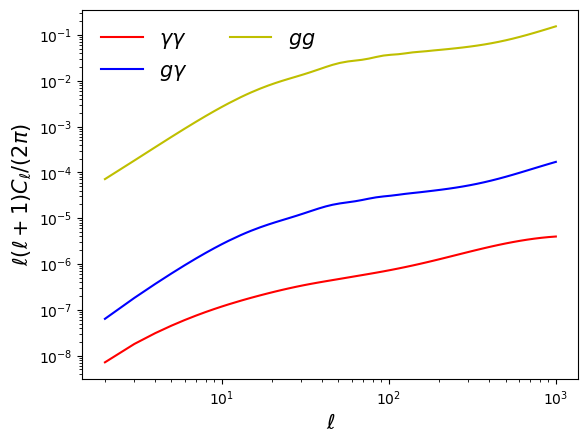

In [51]:
plt.figure()
# look up what this function is measuring/doing
lfac = l_arr * (l_arr + 1) / (2 * np.pi)
plt.plot(l_arr, lfac * cl_MM, 'r-', label='$\gamma\gamma$')
plt.plot(l_arr, lfac * cl_gM, 'b-', label='$g\gamma$')
plt.plot(l_arr, lfac * cl_gg, 'y-', label='$gg$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left', fontsize=15, ncol=2, frameon=False)
plt.ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$', fontsize=15)
plt.xlabel(r'$\ell$', fontsize=15);